In [503]:
import pints
import numpy as np
import math
from scipy.constants import N_A
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from scipy.optimize import fsolve, brentq
import pandas as pd
from lmfit import Model

In [504]:
#Constants

Target_cell_number = 1e4
E_T_ratio = 1
well_size = 50e-6
sigma = well_size*N_A/Target_cell_number
synapse_gap = 25e-9
synapse_width = 9.95e-6
tumour_cell_radius = 8e-6
tumour_cell_surface_area = 4*math.pi*((tumour_cell_radius)**2)
tumour_cell_IS_proportion = (synapse_width**2)/(tumour_cell_surface_area)
NK_cell_radius = 6e-6
NK_cell_surface_area = 4*math.pi*((NK_cell_radius)**2)
NK_cell_IS_proportion = (synapse_width**2)/NK_cell_surface_area
assay_to_synapse_conversion = (synapse_width**2*synapse_gap)/well_size
sigma_synapse = sigma*assay_to_synapse_conversion
synapse_area = synapse_width**2


t_end = 60*60*5
t = np.geomspace(1e-10, t_end, 50)
tspan = [1e-10, t_end]

t_end1 = 60*60*1
t1 = np.geomspace(1e-10, t_end1, 50)
tspan1 = [1e-10, t_end1]

t_end2 = 60*60*0.45
t2 = np.geomspace(1e-10, t_end2, 50)
tspan2 = [1e-10, t_end2]

kons = [1.1e5, 1.4e5, 2e5, 2.5e5]
KDs = [148e-9, 24e-9, 7e-9, 0.6e-9]
koffs = [kons[i]*KDs[i] for i in range(len(kons))]
qon = 6.5e3
qoff = 4.7e-3
rtot = 2.2e5
ftot=2.2e5
D_t = 6.8e-15
D_f = 7.4e-14

In [505]:
#extract data
data1 = []
ftot_synapse = ftot*NK_cell_IS_proportion
from pathlib import Path
pathlist = Path('/Users/lukeheirene/ADCC-Project/GSK_mono_biv_project/Synapse Model Parameter Fitting/Mazor_cyto_data/MTD').glob('**/*.csv')

for path in pathlist:
    print(path)
    df = pd.read_csv(str(path))
    conc = df['CONCENTRATION'].values
    conc = conc*1e-9
    vals = df['RLU'].values
    data1.append(vals)

data = np.stack((data1), axis=1)
data2 = np.asarray(np.concatenate(([data1[i] for i in range(len(data1))])))
A0s = conc

/Users/lukeheirene/ADCC-Project/GSK_mono_biv_project/Synapse Model Parameter Fitting/Mazor_cyto_data/MTD/VKF94A_VHP97A_cyto.csv
/Users/lukeheirene/ADCC-Project/GSK_mono_biv_project/Synapse Model Parameter Fitting/Mazor_cyto_data/MTD/VKS93A_VHP97A_cyto.csv
/Users/lukeheirene/ADCC-Project/GSK_mono_biv_project/Synapse Model Parameter Fitting/Mazor_cyto_data/MTD/VKF94A_cyto.csv
/Users/lukeheirene/ADCC-Project/GSK_mono_biv_project/Synapse Model Parameter Fitting/Mazor_cyto_data/MTD/WT_cyto.csv


In [506]:
def model_eqns(t, z, kon, KD, k2, rtot, Ainit):
    Atot = Ainit*sigma
    k1 = kon/sigma
    A0 = Atot - z[0] - z[1]
    r = rtot - z[0] - 2*z[1]

    dA1 = 2*k1*r*A0 - (KD*kon)*z[0] - k2*r*z[0] + 2*(KD*kon)*z[1]
    dA2 = k2*z[0]*r - 2*(KD*kon)*z[1]

    return [dA1, dA2]

def model_eqns_E(t, z, kon, KD, rtot, Atot):
    k1 = kon/sigma*E_T_ratio
    A0 = Atot - z[0]
    r = rtot - z[0] 

    dA1 = k1*r*A0 - (KD*kon)*z[0] 

    return [dA1]


In [507]:
def A1_steady_state(x, Atot, k1, koff, k2, rtot):
    express = 2*k1*(rtot - x - 2*(k2*x*(rtot-x)/(2*(koff + k2*x))))*(Atot - x - (k2*x*(rtot-x)/(2*(koff + k2*x)))) -koff*x - k2*x*(rtot - x - 2*(k2*x*(rtot-x)/(2*(koff + k2*x)))) +2*koff*(k2*x*(rtot-x)/(2*(koff + k2*x)))

    return express

def A2_steady_state(x, k2, koff, rtot):
    express = k2*x*(rtot-x)/(2*(koff + k2*x))

    return express

#Effector cell opsonization

def effector_A1(ftot, Atot, Q_D):

    a = 1
    b = -(ftot + Atot + Q_D)
    c = ftot*Atot

    return (-b - np.sqrt(b**2 - 4*a*c))/(2*a)

def S_two_cells(t, z, k1, k2, k3, k4, k5, k6, k7, k1off, k2off, rtot_synapse, rtot_fc_synapse, Atot):


    A0 = Atot - (z[0] + z[1] + z[3] + z[4] + z[2])
    rt = rtot_synapse- z[0] - z[3] - 2*(z[1] + z[4])
    rf = rtot_fc_synapse - z[2] - (z[3] + z[4])
    
    dA10 =  - k2*z[0]*(rt) + 2*1*k1off*z[1] - k4*z[0]*(rf) + 1*k2off*z[3]
    dA20 = k2*z[0]*(rt) - 2*1*k1off*z[1] - k5*z[1]*(rf) + 1*k2off*z[4]
    dA01 =   - 2*k6*1*z[2]*(rt) + k1off*1*z[3]
    dA11 = k4*z[0]*(rf) - 1*k2off*z[3] + 2*k6*1*z[2]*(rt) -k1off*1*z[3] - k7*z[3]*(rt) + 2*1*k1off*z[4]
    dA21 = k5*z[1]*(rf) - 1*k2off*z[4] + k7*z[3]*(rt) - 2*1*k1off*z[4]
    dz = [dA10, dA20, dA01, dA11, dA21]

    return dz

In [508]:
def calc_crosslinks_odes(Ainit, kon, koff, D_t, rtot, qon, qoff, D_f, ftot, E_T_ratio, k4, k5, k6, k2):
    
    #k2 = D_t/tumour_cell_surface_area
    #k2 = 10**(-4)
    k1 = kon/sigma
    q1 = qon/sigma
    Q_D = qoff/q1

    Atot = Ainit*sigma
    
    z = solve_ivp(model_eqns, tspan1, [0,0], method='Radau', t_eval=t1, args=(kon, koff/kon, k2, rtot, Ainit))
    A1 = z.y[0]
    A2 = z.y[1]
    A1_st_sin = A1[-1]
    A2_st_sin = A2[-1]
    
        
    Atot = Atot - A1_st_sin - A2_st_sin
    Atot = Atot/E_T_ratio
    z1 = solve_ivp(model_eqns_E, tspan2, [0], method='Radau', t_eval=t2, args=(qon, qoff/qon, ftot, Atot))
    A1e = z1.y[0]
    A1_E_stst = A1e[-1]
        
    A1_pre_synapse = np.float64(A1_st_sin*tumour_cell_IS_proportion)
    A2_pre_synapse = np.float64(A2_st_sin*tumour_cell_IS_proportion)
    A1_E_pre_synapse = np.float64(A1_E_stst*NK_cell_IS_proportion)
    rtot_synapse = rtot*tumour_cell_IS_proportion
    ftot_synapse = ftot*NK_cell_IS_proportion
    Atot =A1_pre_synapse + A2_pre_synapse + A1_E_pre_synapse
    z_0 = [A1_pre_synapse, A2_pre_synapse, A1_E_pre_synapse, 0, 0]
    k1 = kon/sigma_synapse
    k3 = qon/sigma_synapse
    k2 = D_t/(synapse_area)
    k7 = (2*D_t/synapse_area)
    z = solve_ivp(S_two_cells, tspan, z_0, method='BDF',  rtol = 1e-4, atol=1e-3, t_eval=t, args=[k1, k2, k3, k4, k5, k6, k7, koff, qoff, rtot_synapse, ftot_synapse, Atot])
    if z.success == False:
        print(z.message)
    A11 = z.y[3]
    A21 = z.y[4]
  

    crosslinks = (A11[-1] + A21[-1])
    
    
    return np.asarray([A11[-1], A21[-1]])

In [509]:
def fc_func(Emax, Efc50, fc):

    return (Emax*(fc))/(Efc50 + (fc))

def simulate_model_individual(k2, k4, k5, k6, C1, ftot, kon, koff, C2):

    solution = np.zeros_like(A0s)
    ftot_synapse = ftot*NK_cell_IS_proportion
    for i, Ainit in enumerate(A0s):
        vals  = (calc_crosslinks_odes(Ainit, kon, koff, D_t, rtot, qon, qoff, D_f, ftot, E_T_ratio, k4, k5, k6, k2))/ftot_synapse
        A1 = vals[0]
        A2 = vals[1]
        solution[i] = C1*A1 + C2*A2
    
    #solution = fc_func(Emax, Efc50, solution)
    return solution

def simulate_model(x, k2, k4, k5, k6, C1, C2):
    k2 = 10**k2
    k4 = 10**k4
    k5 = 10**k5
    k6 = 10**k6
    solutions = []
    for i, kon in enumerate(kons):
        solution1 = np.zeros((len(A0s)))
        solution1[:] = simulate_model_individual(k2, k4, k5, k6, C1, ftot, kon, koffs[i], C2)
        solutions.append(solution1)
    
    solution = np.asarray(np.concatenate(([solutions[i] for i in range(len(solutions))])))
    return solution
    

In [510]:
ls_model = Model(simulate_model)
print(ls_model.param_names)
print(ls_model.independent_vars)
ls_model.set_param_hint('k2', min = -8, max = -2)
ls_model.set_param_hint('k4', min = -12, max = -0.5)
ls_model.set_param_hint('k5', min = -12, max = -1)
ls_model.set_param_hint('k6', min = -12, max = -1)
ls_model.set_param_hint('C1', min = 0.01, max = 1000)
ls_model.set_param_hint('C2', min = 0.01, max = 1000)

parameters = ls_model.make_params(k2=-4, k4=-5, k5 = -9, k6=-5, C1=20, C2=20)

result = ls_model.fit(data2, parameters, x=A0s)

['k2', 'k4', 'k5', 'k6', 'C1', 'C2']
['x']


In [511]:
print(result.fit_report())

[[Model]]
    Model(simulate_model)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 112
    # data points      = 36
    # variables        = 6
    chi-square         = 16.2973332
    reduced chi-square = 0.54324444
    Akaike info crit   = -16.5306284
    Bayesian info crit = -7.02951473
    R-squared          = 0.97779605
[[Variables]]
    k2: -5.37460591 +/- 0.04633367 (0.86%) (init = -4)
    k4: -1.71861378 +/- 37.9915291 (2210.59%) (init = -5)
    k5: -6.43211460 +/- 0.14222996 (2.21%) (init = -9)
    k6: -5.47978457 +/- 2.18987765 (39.96%) (init = -5)
    C1:  56.7077825 +/- 90.3502458 (159.33%) (init = 20)
    C2:  47.6007252 +/- 2.25574088 (4.74%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(k6, C1) = -0.9943
    C(k5, C2) = -0.8090
    C(k5, C1) = -0.6843
    C(k5, k6) = +0.6812
    C(k6, C2) = -0.4108
    C(C1, C2) = +0.3713
    C(k2, C2) = -0.1853
    C(k2, k5) = +0.1369


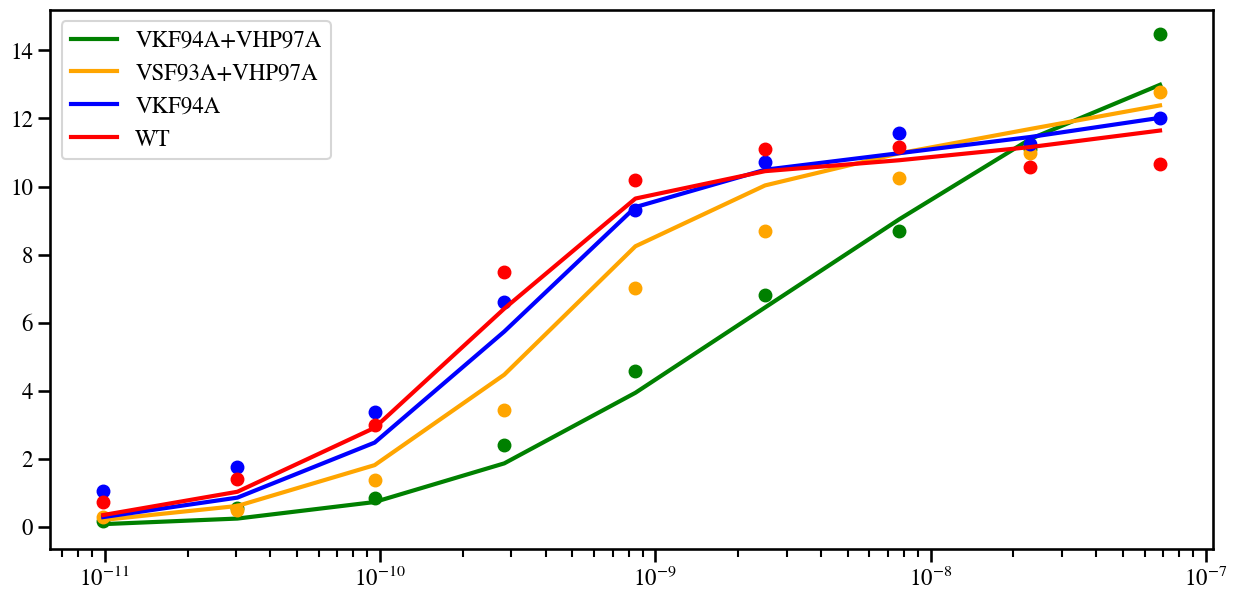

In [512]:
plt.figure(figsize=(15, 7))
param_results = result.best_values
colors=['green', 'orange', 'blue', 'red']
labels = ['VKF94A+VHP97A', 'VSF93A+VHP97A', 'VKF94A', 'WT',]
vals = simulate_model(A0s, param_results['k2'], param_results['k4'], param_results['k5'], param_results['k6'], param_results['C1'], param_results['C2'])
for i in range(len(kons)):
    plt.plot(A0s, data[:, i], 'o', c=colors[i])
    plt.plot(conc, vals[i*9: 9*(i+1)], label=labels[i], lw=3, c=colors[i])
plt.legend()
plt.xscale('log')
plt.show()

In [513]:
init_guesses = [param_results['k4'], param_results['k5'], param_results['k6'], param_results['C1'], param_results['C2']]
k2 = 10**param_results['k2']

In [514]:
def fc_func(Emax, Efc50, fc):

    return (Emax*(fc))/(Efc50 + (fc))

def simulate_model_individual(A0s, k4, k5, k6, C1, ftot, kon, koff, C2):

    solution = np.zeros_like(A0s)
    ftot_synapse = ftot*NK_cell_IS_proportion
    for i, Ainit in enumerate(A0s):
        vals  = (calc_crosslinks_odes(Ainit, kon, koff, D_t, rtot, qon, qoff, D_f, ftot, E_T_ratio, k2, k4, k5, k6))/ftot_synapse
        A1 = vals[0]
        A2 = vals[1]
        solution[i] = C1*A1 + C2*A2
    
    #solution = fc_func(Emax, Efc50, solution)
    return solution

def simulate_model(A0s, parameters):
    k4 = parameters[0]
    k4 = 10**k4
    k5 = parameters[1]
    k5 = 10**k5
    k6 = parameters[2]
    k6 = 10**k6
    C1 = parameters[3]
    C2 = parameters[4]
    solution1 = np.zeros((len(A0s), len(kons)))
    for i, kon in enumerate(kons):
            solution1[:, i] = simulate_model_individual(A0s, k4, k5, k6, C1, ftot, kon, koffs[i], C2)
        
    return solution1
    
class model(pints.ForwardModel):

    def n_outputs(self):
         return 4
    
    def n_parameters(self):
        return 5
    
    def simulate(self, parameters, A0s):
        return simulate_model(A0s, parameters)

In [515]:
class LogPosteriorWrapper(pints.LogPDF):
    def __init__(self, log_pdf):
        self._log_pdf = log_pdf

    def __call__(self, parameters):
        # Create parameter container
        params = np.empty(shape=len(parameters)+3)

        # Fill container with parameters
        # (This solution is specific to the above presented problem)
        params[:5] = np.asarray(parameters[:5])
        params[5] = parameters[5]
        params[6] = parameters[5]
        params[7] = parameters[5]
        params[8] = parameters[5]

        return self._log_pdf(params)

    def n_parameters(self):
        return self._log_pdf.n_parameters() - 3

In [516]:
mod = model()
problem = pints.MultiOutputProblem(mod, conc, data)
log_likelihood = pints.GaussianLogLikelihood(problem)
parameters = init_guesses + [0.01 for i in range(4)]
print(parameters)
log_prior = pints.UniformLogPrior(
    [-12, -12, -12, 0.01, 0.01, 0.00001, 0.00001, 0.00001, 0.00001],
    [-1, -1, -1, 1000, 1000, 3, 3, 3, 3]
)

log_posterior = pints.LogPosterior(log_likelihood, log_prior)

log_posterior_fixed_noise = LogPosteriorWrapper(log_posterior)

[np.float64(-1.718613781044791), np.float64(-6.4321145985456845), np.float64(-5.479784565201944), np.float64(56.70778253244339), np.float64(47.600725220567035), 0.01, 0.01, 0.01, 0.01]


In [517]:
parameters_fixed_noise = init_guesses + [0.01]

In [518]:
xs = [
    np.array(parameters_fixed_noise) * 0.9,
    np.array(parameters_fixed_noise) * 1.01,
    np.array(parameters_fixed_noise) * 1.15
]

In [519]:
mcmc = pints.MCMCController(log_posterior_fixed_noise, 3, xs)
mcmc.set_max_iterations(15000)
chains = mcmc.run()

Using Haario-Bardenet adaptive covariance MCMC
Generating 3 chains.
Running in sequential mode.
Iter. Eval. Accept.   Accept.   Accept.   Time m:s
0     3      0         0         0          0:01.5
1     6      0         0.5       0.5        0:02.9
2     9      0         0.667     0.333      0:04.4
3     12     0         0.75      0.25       0:05.4
20    63     0.286     0.524     0.381      0:29.2
40    123    0.293     0.415     0.439      0:56.2
60    183    0.213     0.426     0.361      1:25.2
80    243    0.222     0.395     0.358      1:48.2
100   303    0.228     0.356     0.327      2:15.4
120   363    0.24      0.314     0.306      2:42.8
140   423    0.241     0.319     0.298      3:11.4
160   483    0.224     0.304     0.286      3:39.9
180   543    0.221     0.276     0.265      4:07.4
Initial phase completed.
200   603    0.199005  0.254     0.269      4:34.8
220   663    0.217     0.276     0.271      5:03.0
240   723    0.241     0.29      0.295      5:28.8
260   783   

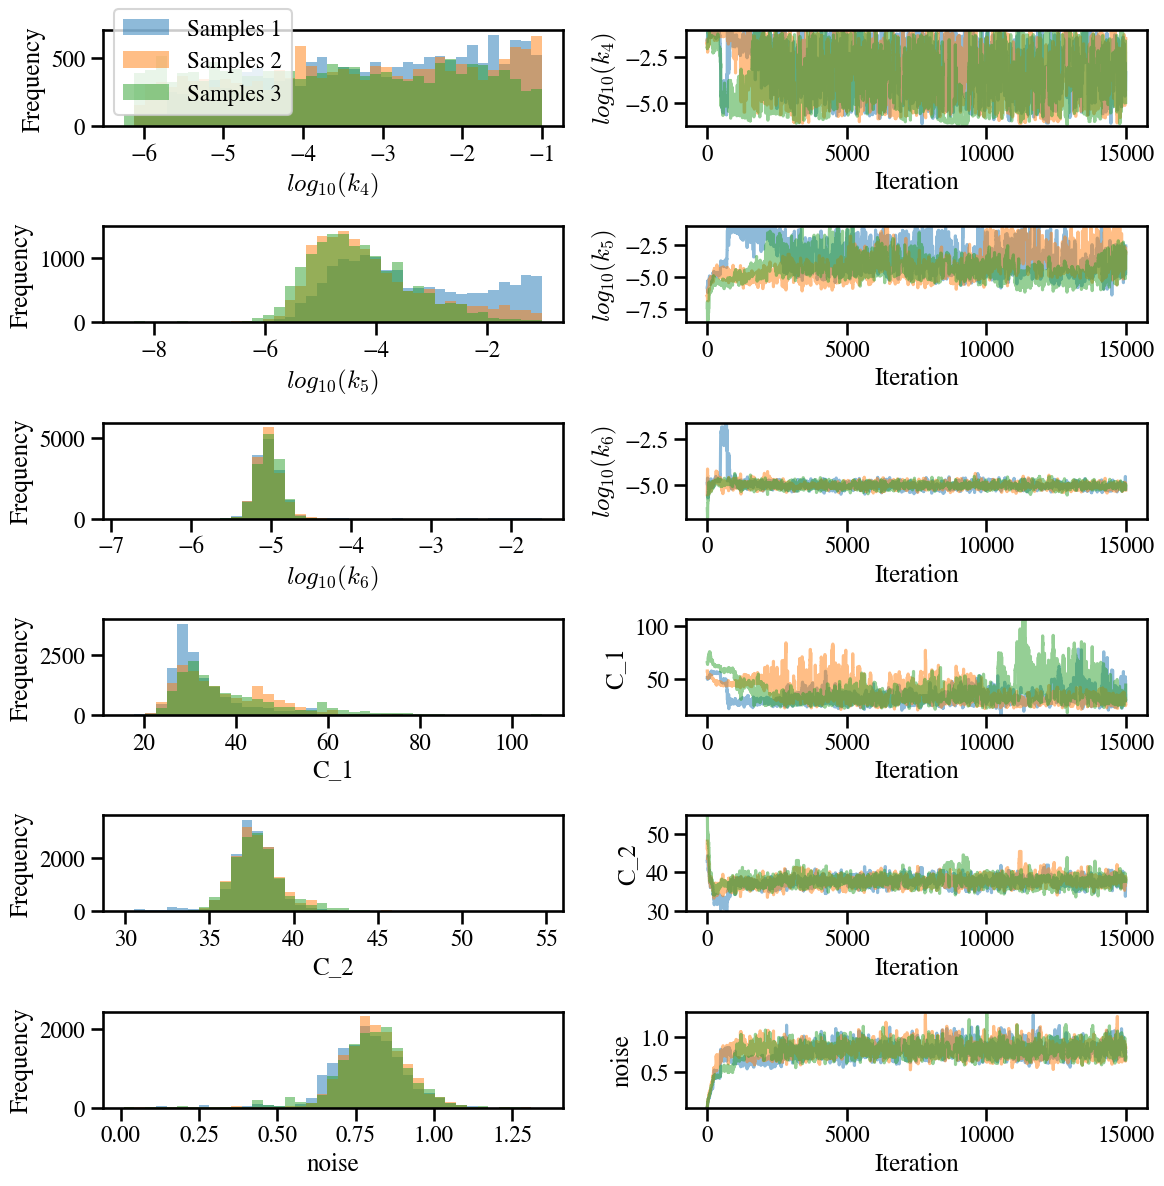

In [520]:
import pints.plot
pints.plot.trace(chains, parameter_names=[r'$log_{10}(k_4)$', r'$log_{10}(k_5)$', r'$log_{10}(k_6)$', r'C_1', r'C_2', 'noise'])
plt.show()

In [521]:
chain = chains[0]
chain = chain[10000:]
chains1 = chains[:, 10000 :]

In [522]:
results = pints.MCMCSummary(chains=chains1, time=mcmc.time(),parameter_names=[r'log10(k4)', r'log10(k5)', r'log10(k6)', r'C_1', r'C_2',  'noise'])
print(results)


param      mean    std.    2.5%    25%    50%    75%    97.5%    rhat    ess     ess per sec.
---------  ------  ------  ------  -----  -----  -----  -------  ------  ------  --------------
log10(k4)  -3.43   1.39    -5.92   -4.52  -3.40  -2.25  -1.16    1.02    296.30  0.02
log10(k5)  -3.82   1.17    -5.64   -4.71  -4.03  -3.02  -1.32    1.21    205.94  0.01
log10(k6)  -5.05   0.15    -5.33   -5.15  -5.05  -4.95  -4.75    1.01    411.69  0.03
C_1        36.03   12.09   24.04   28.49  31.99  38.72  72.19    1.18    234.95  0.01
C_2        37.93   1.44    35.44   37.01  37.82  38.68  41.24    1.03    330.27  0.02
noise      0.82    0.10    0.65    0.75   0.81   0.89   1.04     1.01    402.08  0.02


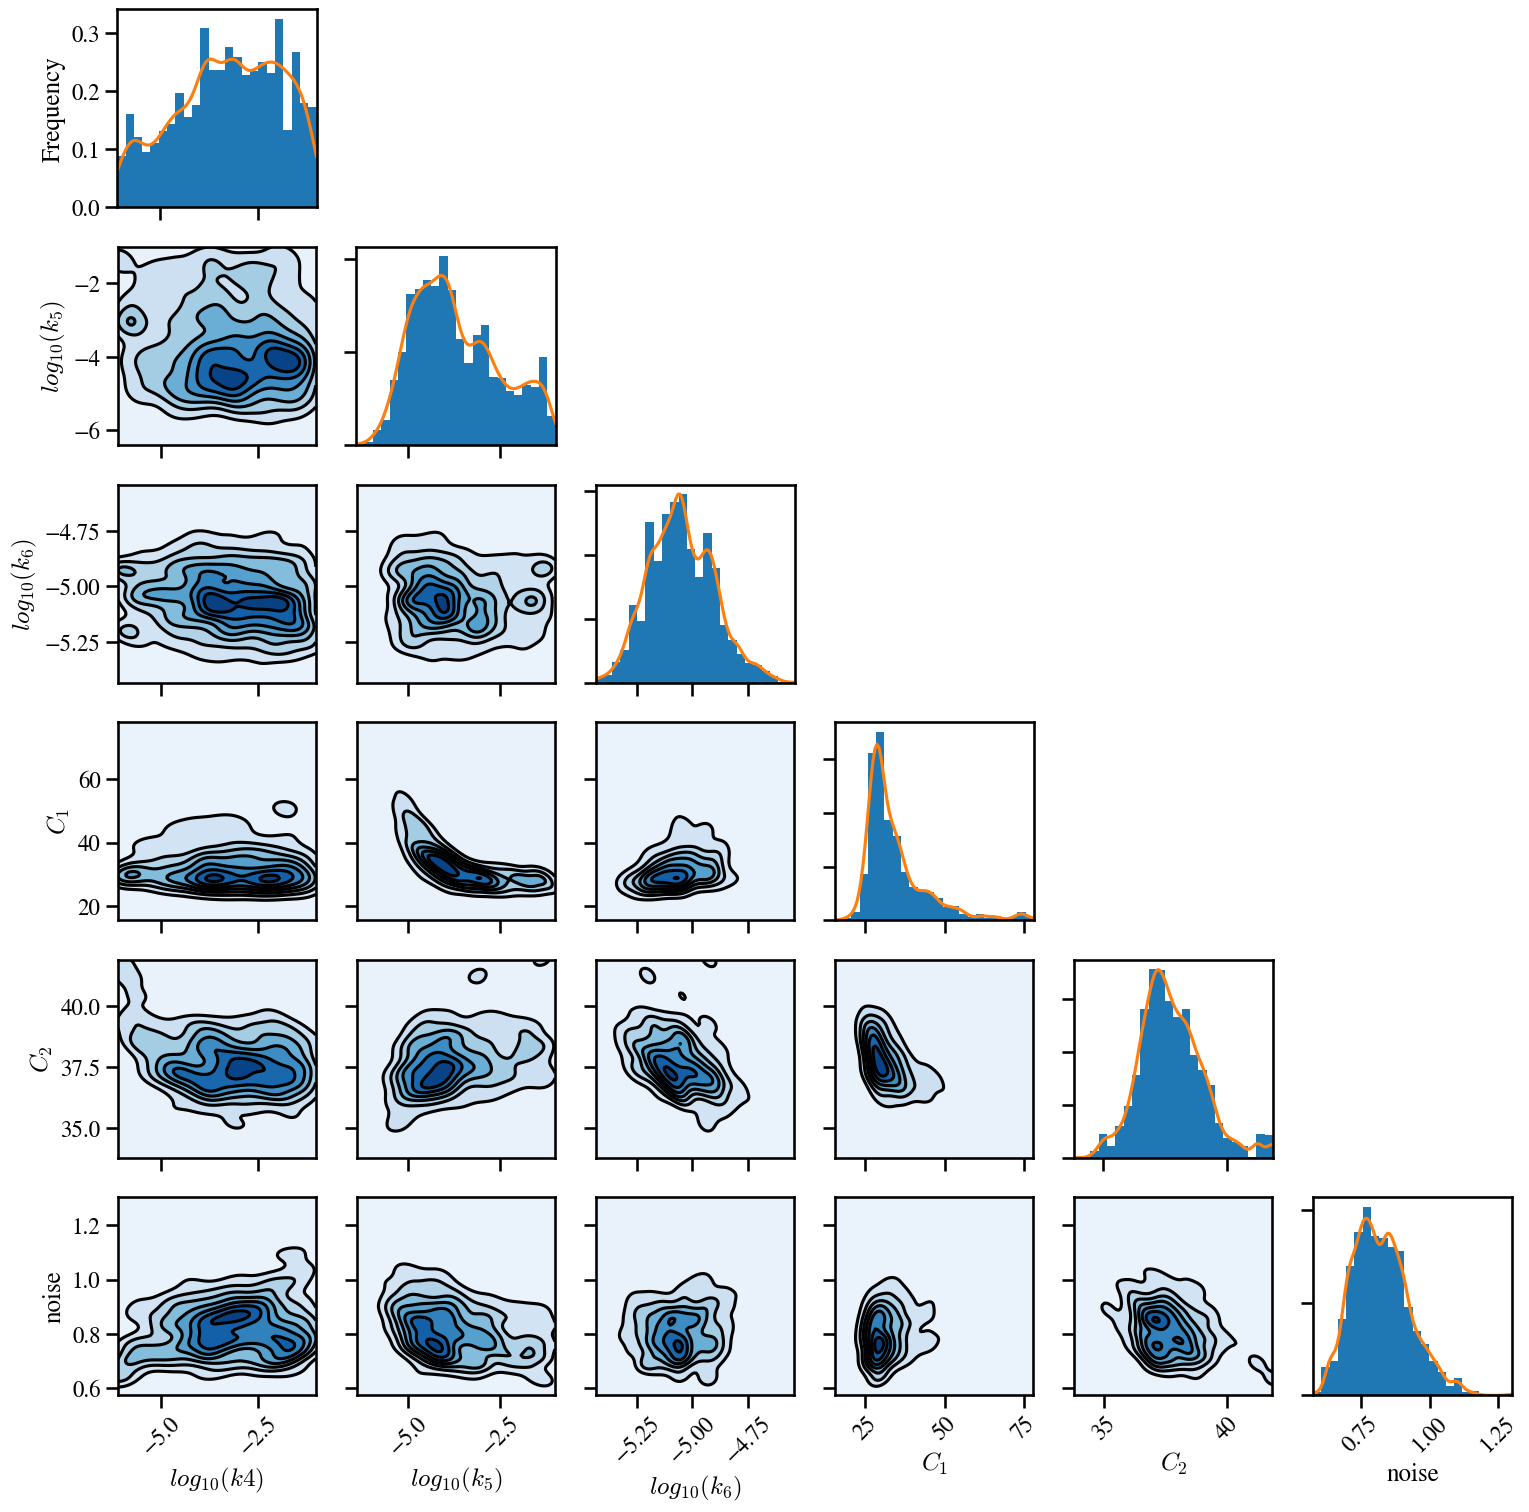

In [523]:
pints.plot.pairwise(chain, kde=True,  parameter_names=[r'$log_{10}(k4)$', r'$log_{10}(k_5)$', r'$log_{10}(k_6)$', r'$C_1$', r'$C_2$', 'noise'])
plt.show()

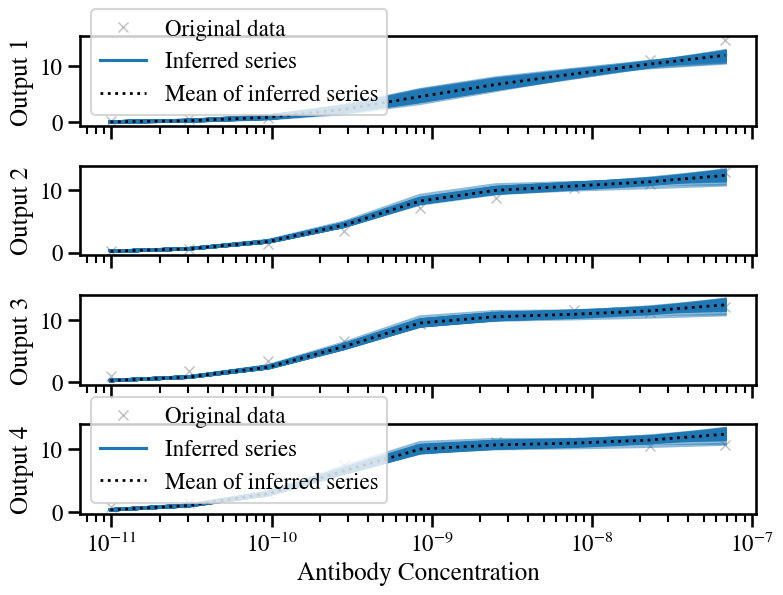

In [524]:
fig, axes = pints.plot.series(chains1[0], problem)

#fig.set_size_inches(12,4.5)
#plt.plot(A0s1, values, c='orange', label='data')
plt.legend()
plt.xscale('log')
plt.xlabel(r'Antibody Concentration')
plt.show()

In [525]:
results_list = results._summary_list
results_dic = {}
means =[]
stds = []
l_perc = []
h_perc = []
rhats = []
parameter_names=[r'log10(k4)', r'log10(k5)', r'log10(k6)', r'C_1', r'C_2', 'noise1']
for i, param in enumerate(parameter_names):
    holder = results_list[i]
    means.append(holder[1])
    stds.append(holder[2])
    l_perc.append(holder[3])
    h_perc.append(holder[7])
    rhats.append(holder[8])

results_dic['parameter'] = parameter_names
results_dic['mean'] = means
results_dic['std'] = stds
results_dic['2.5%'] = l_perc
results_dic['97.5%'] = h_perc
results_dic['rhat'] = rhats

In [526]:
print(results_dic['mean'])

[np.float64(-3.4276449478682838), np.float64(-3.8186214154311635), np.float64(-5.048404093161384), np.float64(36.02592913328616), np.float64(37.93304638093031), np.float64(0.8239342334586643)]


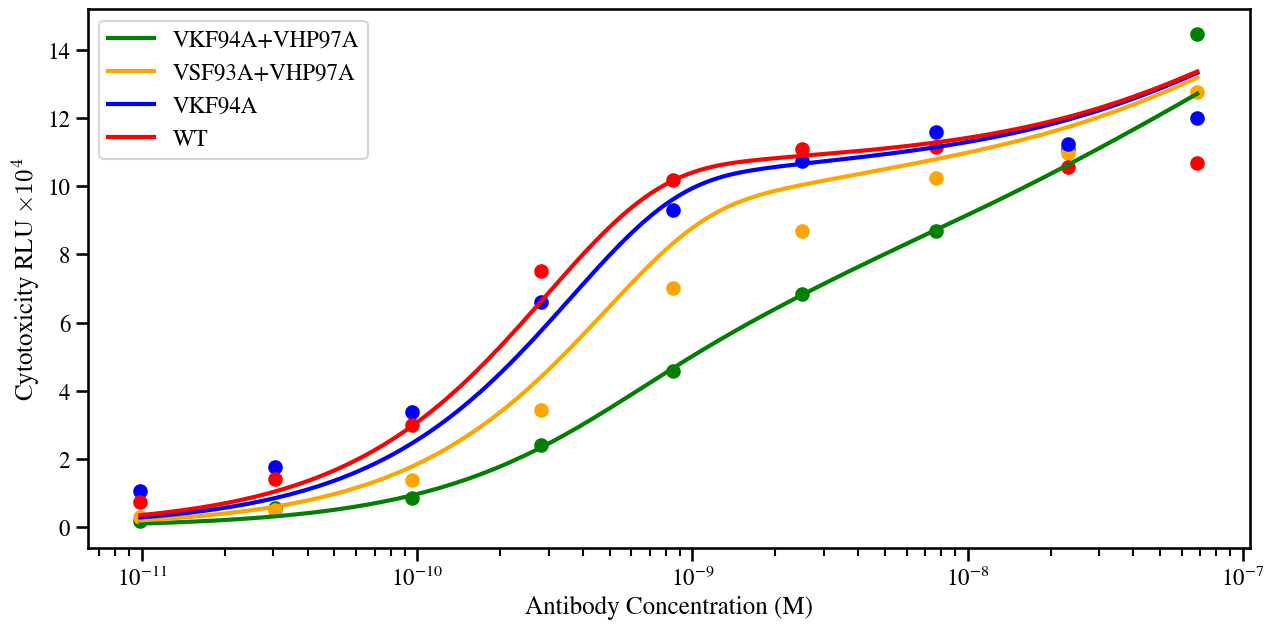

In [527]:
import matplotlib
matplotlib.rcParams['mathtext.fontset'] = 'cm'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
A0s = np.geomspace(np.min(conc), np.max(conc), 150)
SMALL_SIZE =10
MEDIUM_SIZE = 10
BIGGER_SIZE = 12

matplotlib.rc('font', size=SMALL_SIZE)
matplotlib.rc('axes', titlesize=BIGGER_SIZE)
import seaborn as sns
sns.set_context('talk')

plt.figure(figsize=(15, 7))
plt.xlabel('Antibody Concentration (M)')
plt.ylabel(r'Cytotoxicity RLU $\times 10^4$')

parameters=results_dic['mean']
#parameters = [np.float64(-6.337053447734297), np.float64(-8.193659215136035), np.float64(-7.0971636246953596), np.float64(0.3040548518999335), np.float64(0.8786846642185841), np.float64(0.13890972065515947), np.float64(0.04155340220718492), np.float64(0.03355178641841207), np.float64(0.06273472762480574)]
sim = simulate_model(A0s, parameters)
colors=['green', 'orange', 'blue', 'red']
labels = ['VKF94A+VHP97A', 'VSF93A+VHP97A', 'VKF94A', 'WT',]
for i in range(len(kons)):
    plt.plot(A0s, sim[:, i], c=colors[i], label=labels[i], lw=3)
    plt.scatter(conc, data[:, i], c=colors[i])
plt.xscale('log')
plt.legend(loc='best')
plt.show()

In [528]:
def simulate_model_individual1(A0s, k4, k5, k6, ftot, kon, koff):

    solution = np.zeros_like(A0s)
    ftot_synapse = ftot*NK_cell_IS_proportion
    for i, Ainit in enumerate(A0s):
        solution[i] = (calc_crosslinks_odes(Ainit, kon, koff, D_t, rtot, qon, qoff, D_f, ftot, E_T_ratio, k4, k5, k6))/ftot_synapse
        

    return solution

In [529]:
params = results_dic['mean']
k4=params[0]
k4 = 10**k4
k5=params[1]
k5 = 10**k5
k6=params[2]
k6=10**k6
A0s = np.geomspace(1e-12, 1e-5, 100)
ftot=2.2e5
solution1 = np.zeros((len(A0s), len(kons)))
for i, kon in enumerate(kons):
        solution1[:, i] = simulate_model_individual1(A0s, k4, k5, k6, ftot, kon, koffs[i])

TypeError: calc_crosslinks_odes() missing 1 required positional argument: 'k2'

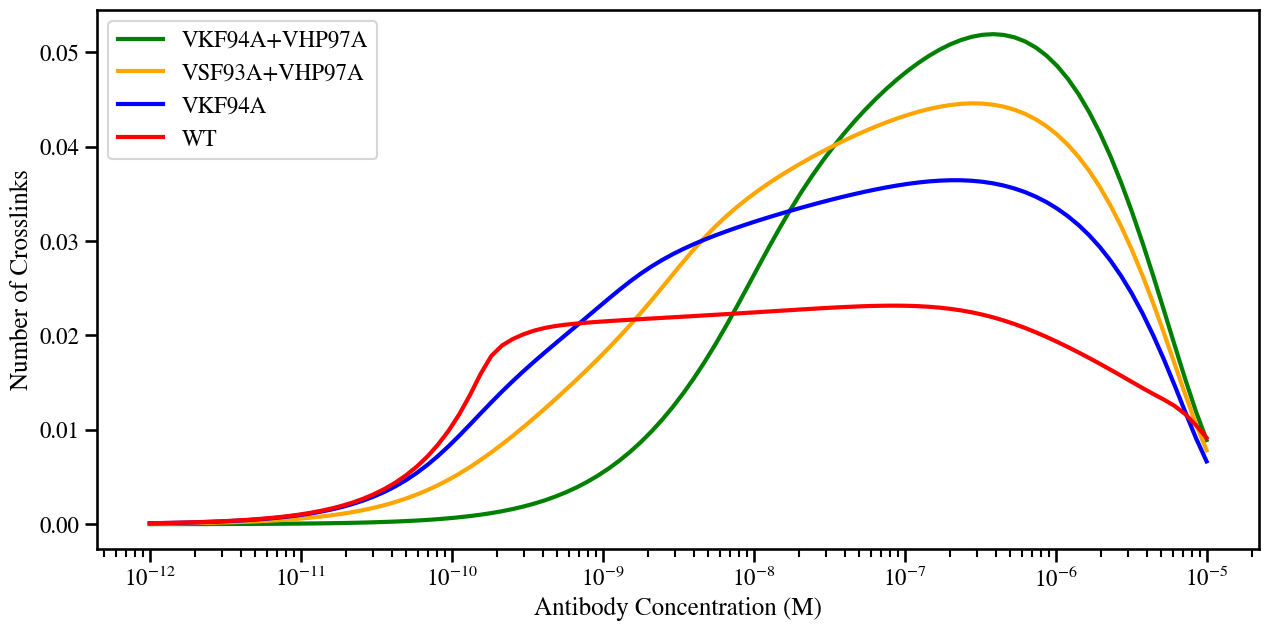

In [ ]:
plt.figure(figsize=(15, 7))
plt.xlabel('Antibody Concentration (M)')
plt.ylabel('Number of Crosslinks')

colors=['green', 'orange', 'blue', 'red']
labels = ['VKF94A+VHP97A', 'VSF93A+VHP97A', 'VKF94A', 'WT',]
for i in range(len(kons)):
    plt.plot(A0s, solution1[:, i], c=colors[i], label=labels[i], lw=3)
plt.xscale('log')
#plt.ylim(0, 0.15)
plt.legend(loc='best')
plt.show()